# Installing and Importing Required Libraries


In [2]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q jiwer
!pip install -q datasets
!pip install -q evaluate
!pip install -q accelerate -U


!pip install -q matplotlib
!pip install -q protobuf==3.20.1
!pip install -q tensorboard


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Among these, some of the important ones are:
  1. transformers: This is the Hugging Face transformers library that gives us access to hundreds of transformer based models including the TrOCR model.
  2. sentencepiece: This is the sentencepiece tokenizer library that is needed to convert words into tokens and numbers. This is also part of the Hugging Face family.
  3. jiwer: The jiwer library gives us access to several speech recognition and language recognition metrics. These include WER (Word Error Rate) and CER (Character Error Rate). We will use the CER metric to evaluate the model while training.

In [3]:
import os
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

Some of the important import statements from the above code block are:
  1. *VisionEncoderDecoderModel*: We need this class to define different TrOCR models.
  2. *TrOCRProcessor*: TrOCR expects the dataset to follow a particular normalization process. This class will ensure that the images are properly normalized and processed.
  3. *Seq2SeqTrainer*: This is needed to initialize the trainer API.
  4. *Seq2SeqTrainingArguments*: While training, the trainer API expects several arguments. The Seq2SeqTrainingArguments class initializes all the required arguments before passing them to the API.
  5. *transforms*: The Torchvision transforms module is needed to apply data augmentation to the images.

Now, set the seed for reproducibility across different runs and define the computation device.


In [4]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download and Extract the Dataset

In [5]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")


    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)


    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])


        print("Done")


    except Exception as e:
        print("\nInvalid file.", e)


URL = r"https://www.dropbox.com/scl/fi/vyvr7jbdvu8o174mbqgde/scut_data.zip?rlkey=fs8axkpxunwu6if9a2su71kxs&dl=1"
asset_zip_path = os.path.join(os.getcwd(), "scut_data.zip")

# Download if asset ZIP does not exist.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

# Defining Configurations


In [6]:
dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 48
    EPOCHS:        int = 35
    LEARNING_RATE: float = 0.00005

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = 'scut_data'

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-printed'

The model will undergo 35 epochs of training using a batch size of 48.  The learning rate for the optimizer is set at 0.00005. Higher learning rates can make the training process unstable leading to higher loss from the beginning.

Furthermore, we also define the root dataset directory and the model that we are going to use. The TrOCR Small Printed model will be fine-tuned, as it demonstrated optimal performance based on experimentation with this dataset.

# Visualizing a Few Samples


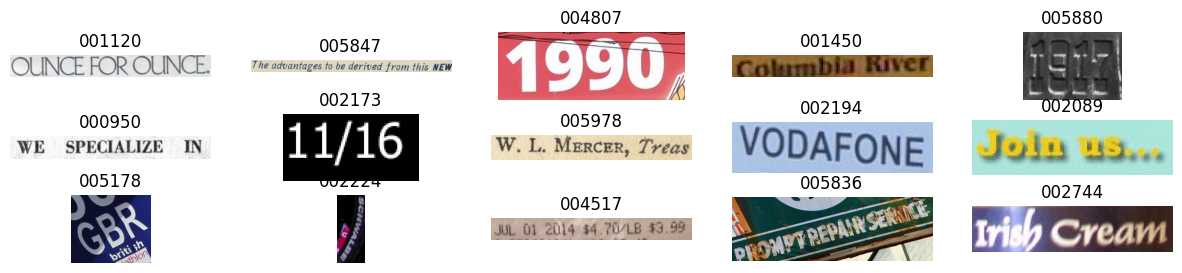

In [7]:
def visualize(dataset_path):
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        all_images = os.listdir(f"{dataset_path}/scut_train")
        image = plt.imread(f"{dataset_path}/scut_train/{all_images[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.title(all_images[i].split('.')[0])
    plt.show()


visualize(DatasetConfig.DATA_ROOT)

#Preparing the Dataset
The labels are present in text file formats. For smoother data loader preparation, they will need to be modified to an easier format. Let’s convert the training and test text files into Pandas DataFrame.



In [8]:
train_df = pd.read_fwf(
    os.path.join(DatasetConfig.DATA_ROOT, 'scut_train.txt'), header=None
)
train_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)
test_df = pd.read_fwf(
    os.path.join(DatasetConfig.DATA_ROOT, 'scut_test.txt'), header=None
)
test_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)

The next step is defining the augmentations.


In [9]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

We apply ColorJitter and GaussianBlur to the images. There is no need to apply any rotation of flipping to the images as there is already enough variability in the original dataset.

The best way to prepare the dataset is to write a custom dataset class. This allows us to have finer control over the inputs. The following code block defines a CustomOCRDataset class to prepare the dataset.

In [10]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['file_name'][idx]
        # The text (label).
        text = self.df['text'][idx]
        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

The __init__() method accepts the root directory path, the DataFrame, TrOCR processor, and the maximum label length as parameters.

The __getitem__() method first reads the label and image from the disk. It then passes the image through the transforms to apply the augmentations. The TrOCRProcessor returns the normalized pixel values in PyTorch tensor format. Next, the text labels are passed through the tokenizer. If a label is shorter than 128 characters, it is padded with -100 to a length of 128. If it is longer than 128 characters, then the characters are truncated.  Finally, it returns the pixel values and the labels as a dictionary.

Before creating the training and validation set, it is necessary to initialize the TrOCRProcessor so that it can be passed to the dataset class.



In [11]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'scut_train/'),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'scut_test/'),
    df=test_df,
    processor=processor
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

# Prepare the TrOCR Small Printed Model

The VisionEncoderDecoderModel class gives us access to all the TrOCR models. The from_pretrained() method accepts the repository name to load a pretrained model.

In [12]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

The model contains 61.5 million parameters. Fine tuning will be done to all the parameters so they can be trained.

One of the most important aspects of model preparation is the model configurations. The configurations are discussed below.

In [13]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id


model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

The pretrained TrOCR model comes with its own set of predefined configurations. However, to fine tune the model, we will overwrite some of them, which include the token IDs, the vocabulary size, and also the End of Sequence token.

Furthermore, early stopping is set to True. This ensures that if the model metrics do not improve for a few consecutive epochs, then the training will stop.

# Optimizer and Evaluation Metric
For optimizing the model weights, we choose the AdamW optimizer with a weight decay of 0.0005.



In [14]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

In [15]:
cer_metric = evaluate.load('cer')


def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions


    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)


    cer = cer_metric.compute(predictions=pred_str, references=label_str)


    return {"cer": cer}

Without elaborating further, CER is basically the number of characters that the model did not predict correctly. The lower the CER, the better the performance of the model.

**Note:** that we are skipping the padding token in the calculation of CER as we do not want the padding token to influence the performance of the model.

# Training and Validation of TrOCR


In [16]:
!nvidia-smi

Sat Mar 23 03:50:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              27W /  70W |    347MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='seq2seq_model_printed/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

The FP16 training is being used as it uses less GPU memory and also allows us to use a higher batch size. Also, the logging and model-saving strategy is based on epochs. All the reports will be logged to tensorboard.

These training arguments will be passed to the trainer API along with the other required arguments.

In [18]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


The training process can be commenced by calling the train() method of the trainer object.



In [ ]:
trainer.args.per_device_train_batch_size = 8
trainer.args.fp16 = True

In [ ]:
res = trainer.train()

Epoch,Training Loss,Validation Loss,Cer
1,3.461200,2.804939,0.744658
2,2.563800,2.681664,0.694273
3,2.062800,2.326522,0.602920
4,1.691600,2.278483,0.580670
5,1.480500,2.216405,0.575078
6,1.322100,2.167580,0.580611
7,1.181800,2.260041,0.562482
8,1.038700,2.234440,0.605804
9,0.912700,2.227522,0.550768
10,0.814700,2.315643,0.591324


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1295: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (http

# Inference using the Fine Tuned TrOCR Model
Having trained the TrOCR model, it's time to run inferences on the validation images.

The first step is to load the trained model from the last saved checkpoint.

In [20]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-'+str(res.global_step)).to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


NameError: name 'res' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

The res object contains a global_step attribute that holds the total number of steps the model was trained for. The above code block uses that attribute to load the weights from the final epoch.

Up next are some helper functions. The first one is to read an image.

In [ ]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.


    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

The next helper function carries out the forward pass of the image through the model.



In [ ]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.


    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

The final helper function loops over all the images in a directory and keeps on calling the ocr() function for inference.



In [ ]:
def eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'scut_test', '*'),
    num_samples=50
):
    image_paths = glob.glob(data_path)
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_and_show(image_path)
        text = ocr(image, processor, trained_model)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()

eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'scut_test', '*'),
    num_samples=100
)